<a href="https://colab.research.google.com/github/Haimzis/BreastCancerClassification/blob/main/BreastCancerClassifierFullPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Pre-requirements

## 1.1 Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import statsmodels
from scipy import stats

import warnings # removing sns style warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, roc_curve, auc
import matplotlib.pyplot as plt

## 1.2. Download dataset

In [ ]:
#### TODO: Fix that
# !pip install -U --no-cache-dir gdown --pre
# !gdown --id ______________________________
# !unzip /content/filename.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/breast_cancer_prediction/breast-cancer.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
# CONSTANTS
ID = 'id'
LABEL = 'diagnosis'
MALIGNANT = 'M'
BENIGN = 'B'

# 2. Dataset Analysis

The Breast Cancer Dataset contains measurements derived from breast cancer x-rays.   
Each entry includes features such as the radius, texture, and area of tumor cells, which are taken from multiple observations or parts of the tumor.  

Therefore, every feature is an aggregation of statistical parameters such as mean, standard error, and maximum (often referred to as "worst").

### Side Note: we're addressing numeric values to each part of the exercise in accordance with the guidelines provided in the workshop document. [link](https://lemida.biu.ac.il/pluginfile.php/3193717/mod_folder/content/0/TDS%20Applied%20Project%20guidelines%20.pdf?forcedownload=1)

## 2.1 Data Structure

dataset columns

In [ ]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

As expected, our data consists over numeric [Floating numbers] measurements.

In [ ]:
non_numeric_cols = [ID, LABEL]
numerical_df = df.drop(non_numeric_cols, axis=1)

Save different dataframe for training

In [ ]:
training_df = numerical_df.copy(deep=True)

In [ ]:
f"Number of Samples: {df.shape[0]}"

'Number of Samples: 569'

### 2.2 Data Distribution Description

In [ ]:
numerical_df.describe().drop('count', axis=0).T

,mean,std,min,25%,50%,75%,max
radius_mean,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


Few things that we can take from this dataset description:
1. Interquartile Range (IQR) - Large IQRs suggest that the majority of data points lie far from the median.  
Examples:
  - area_se
  - area_worst.

2. Range of Data - Large range between the min and max values might indicate significant variability and possibly a presence of outliers/ invalid values. also suggests that we should normalize the data.
Examples:
  - area_worst ranging from 185.2 to 4254.0
  - area_mean ranging from 143.5 to 2501.0

3. Outliers: Significant difference between the Q3 and max value (or min value and Q1) suggest outliers.  
Examples:
  - concavity_worst Q3=0.38, max=1.25
  - area_worst Q3=1084.0, max=4254.0
  - area_se Q3=45.2, max=542.2
  - perimeter_se Q3=3.35, max=21.98
  - area_mean Q3=782.7, max=2501.0

### 2.3 Quantitative Measure of Skewness (i.e. Asymmetry)

In [ ]:
skewness_rate_df = numerical_df.skew().sort_values(ascending=False)
skewness_rate_df

area_se                    5.447186
concavity_se               5.110463
fractal_dimension_se       3.923969
perimeter_se               3.443615
radius_se                  3.088612
smoothness_se              2.314450
symmetry_se                2.195133
compactness_se             1.902221
area_worst                 1.859373
fractal_dimension_worst    1.662579
texture_se                 1.646444
area_mean                  1.645732
compactness_worst          1.473555
concave points_se          1.444678
symmetry_worst             1.433928
concavity_mean             1.401180
fractal_dimension_mean     1.304489
compactness_mean           1.190123
concave points_mean        1.171180
concavity_worst            1.150237
perimeter_worst            1.128164
radius_worst               1.103115
perimeter_mean             0.990650
radius_mean                0.942380
symmetry_mean              0.725609
texture_mean               0.650450
texture_worst              0.498321
concave points_worst       0

The skewness values reveal that all features are right-skewed, particularly those measuring standard error, with texture_se having the lowest skewness among them. This skewness indicates distributions with long right tails, likely influenced by outliers or non-normal distributions. Such skewness can impact statistical analyses and model performance, given the normality assumption of many algorithms. Addressing this may require addresing outliers and normalizing the data.

### 2.4 Data Quality and Nullness

In [ ]:
numerical_df.isnull().sum()

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Based on the null counts provided for the dataset, it can be concluded that there are no missing values across all features listed,
Suggesting that preliminary data cleaning steps for handling missing values may not be necessary.

# 3. Prediction Problem: Binary Classification

## The objective is to predict the diagnosis of breast tissues as either malignant (M) or benign (B). This task involves utilizing a comprehensive set of diagnostic measurements.

# 5. Data Visualizations

In [ ]:
# Visualization Hyperparameters
WHISKER_LEN = 2.

### 5.1 Label Occurences

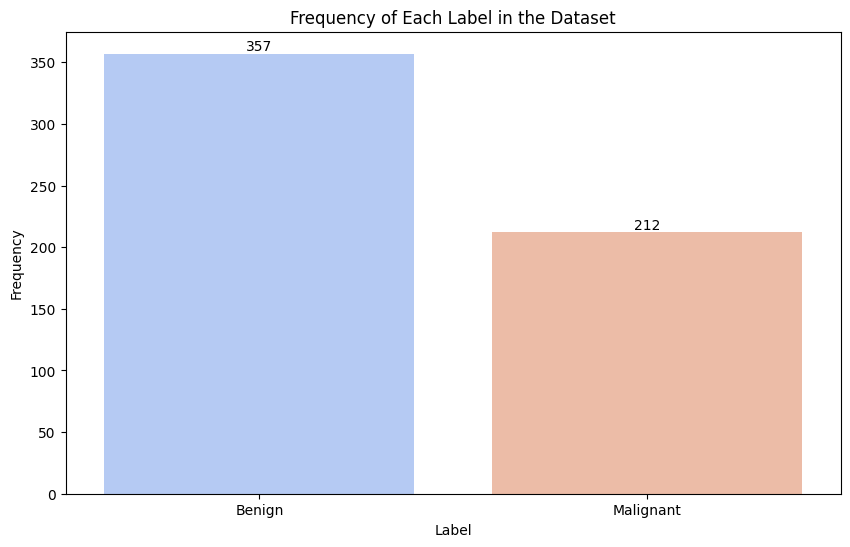

In [ ]:
full_names = {MALIGNANT: 'Malignant', BENIGN: 'Benign'}
label_counts = df[LABEL].value_counts().rename(index=full_names)

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='coolwarm')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in the Dataset')

for index, value in enumerate(label_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

 An imbalance between the two classes, with benign cases being more common than malignant ones by a ratio of ~3:5.

### 5.2 Pair-wise Pearson Correlation Heatmap

In [ ]:
numerical_df[LABEL] = (df[LABEL] == MALIGNANT).astype(float)

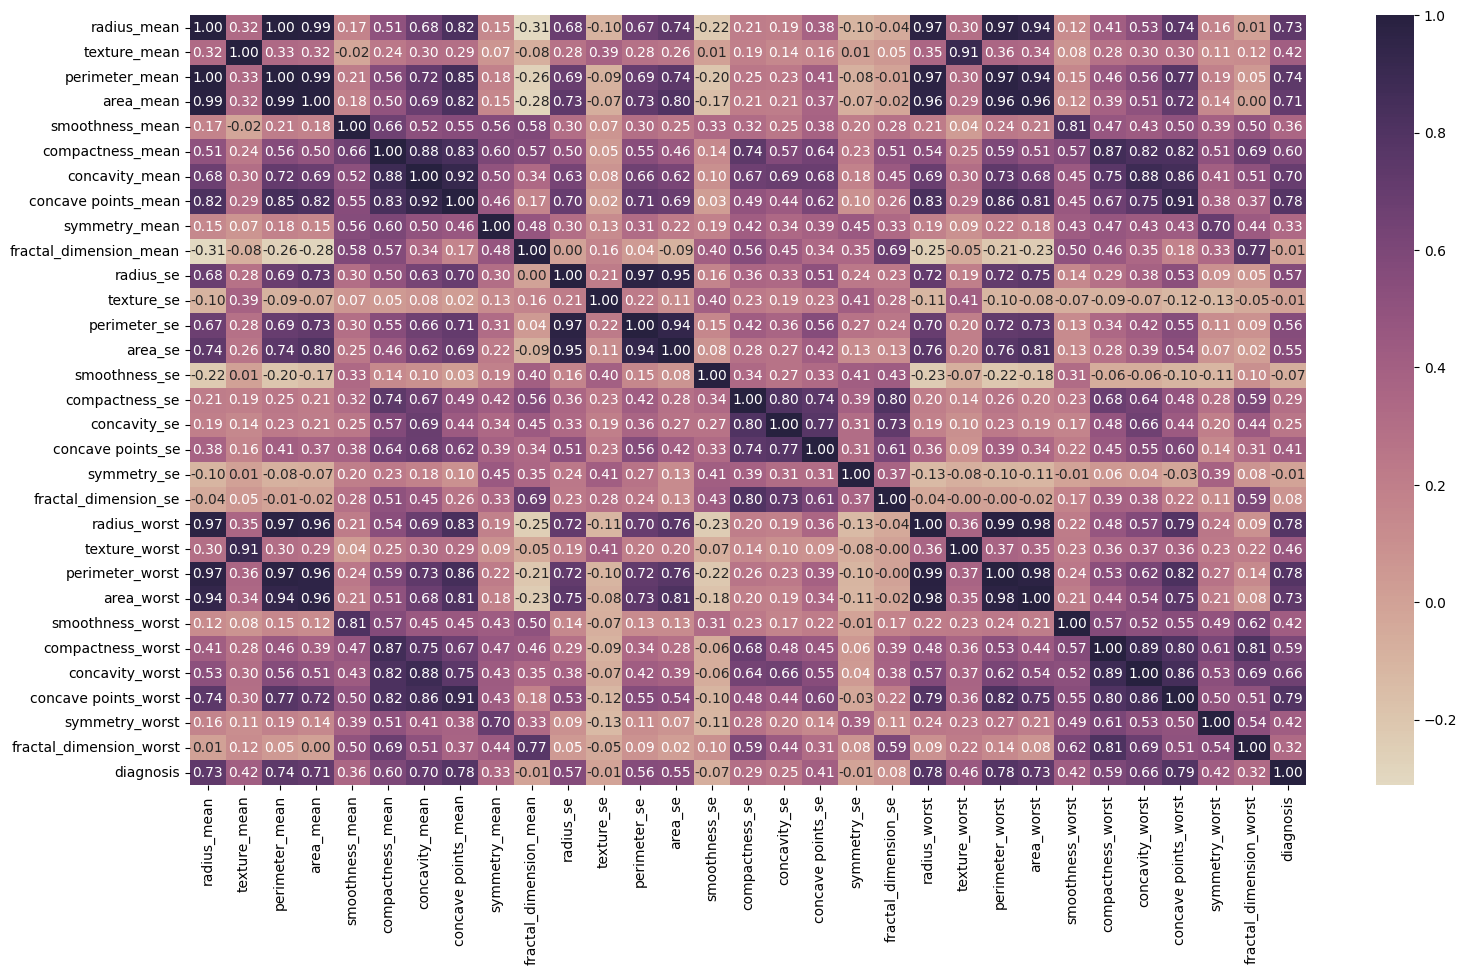

In [ ]:
corr = numerical_df.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(18, 10))
sns.heatmap(corr, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), annot=True, fmt=".2f")
plt.show()

##### Important Considerations from Correlation Matrix for Predictive Modeling

1. **Strong Predictors of Diagnosis**:
   - **`radius_mean`**, **`perimeter_mean`**, **`area_mean`**, **`concavity_mean`**, **`concave points_mean`**, and **`concave points_worst`** have high positive correlations with the diagnosis.
     - *Conclusion*: These are strong predictors for the malignant class and should be considered for inclusion in the model.

2. **Potential Redundancy Among Features**:
   - There is a very high correlation between the following sets of features:
     1. **`radius_mean`**, **`perimeter_mean`**, and **`area_mean`**.
     2. **`compactness_mean`**, **`concavity_mean`**, **`concave points_mean`**, **`compactness_worst`**, **`concavity_worst`**, and **`concave points_worst`**.
     - *Conclusion*: such strong correlations indicate that these feature sub-groups provide very similar information and could potentially be reduced to a single feature each to simplify the model without a significant loss of information.

3. **Features with Moderate Correlation to Diagnosis**:
   - Features such as **`texture_mean`**, **`smoothness_mean`**, **`symmetry_mean`**, and **`fractal_dimension_worst`** have moderate correlations with the diagnosis.
     - They may still contribute to the model but are not as strong predictors as the ones with higher correlations.

4. **Low Correlation with Diagnosis**:
   - Some features like **`fractal_dimension_mean`**, **`texture_se`**, **`fractal_dimension_se`** and **`symmetry_se`** have very low or negligible correlations with the diagnosis.
     - *Conclusion*: These features might be candidates for removal from the model.



### 5.3 Identifying Outliers Across Feature Distributions (Boxplot)

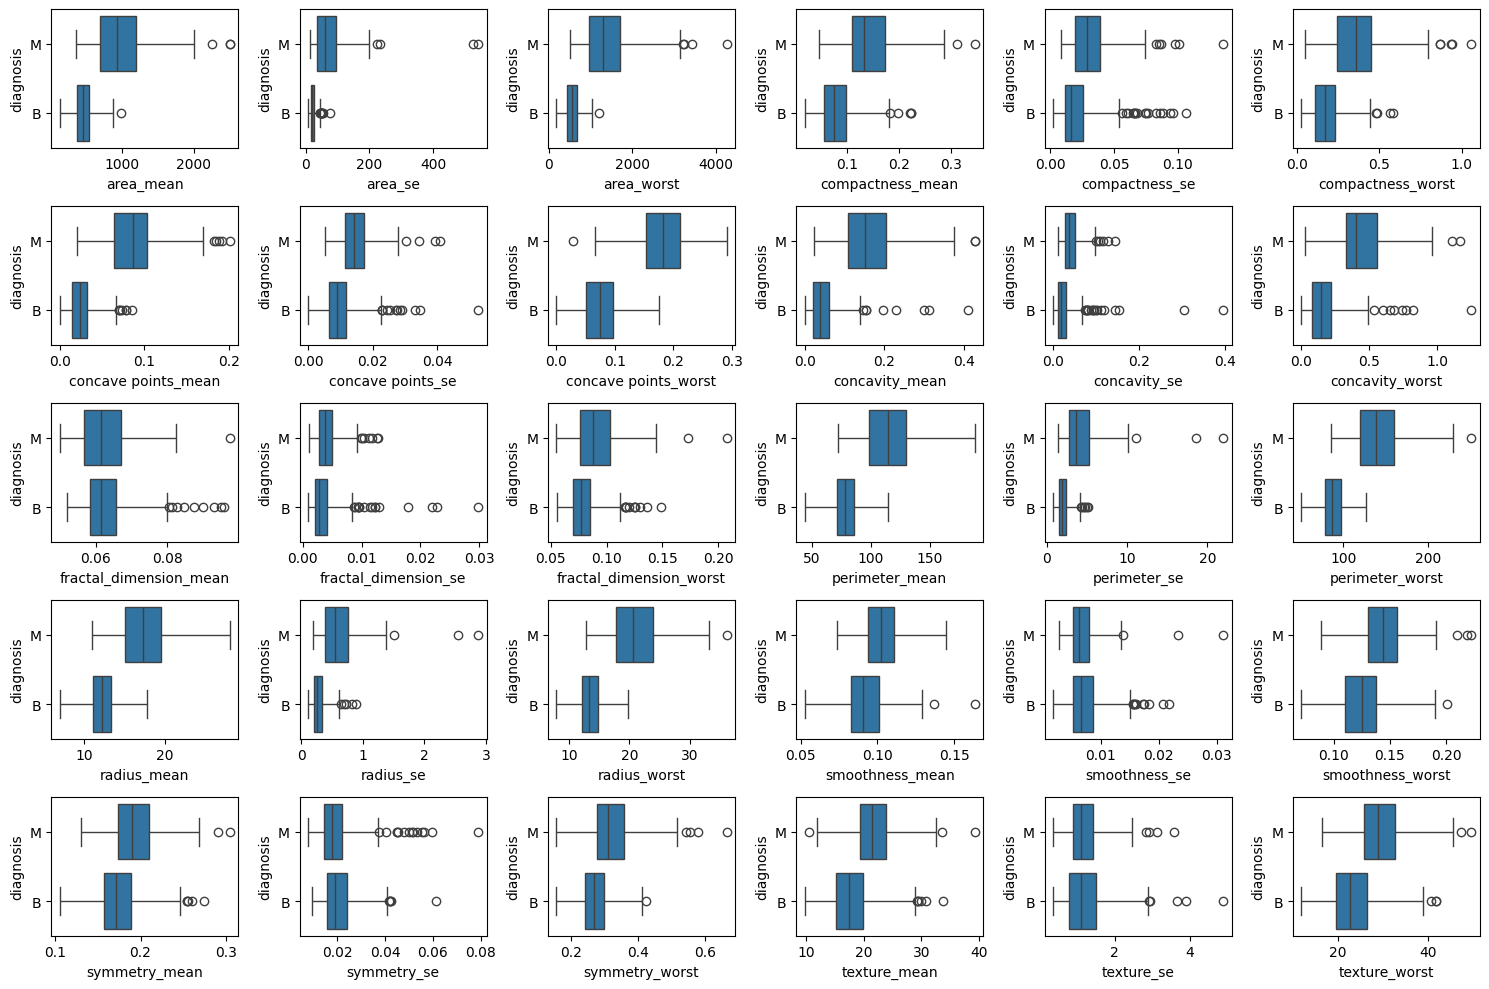

In [ ]:
features_sorted_alpha = sorted(numerical_df.drop(LABEL, axis=1).columns)

num_features = len(features_sorted_alpha)
num_columns = 6
num_rows = num_features // num_columns + (1 if num_features % num_columns > 0 else 0)
WHIS = 2.

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

for i, feature in enumerate(features_sorted_alpha):
    row, col = divmod(i, num_columns)
    sns.boxplot(y="diagnosis", x=feature, data=df, ax=axes[row, col], whis=WHIS)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_columns):
    axes.flat[j].set_visible(False)

plt.tight_layout()
plt.show()


#### Insights

**Size & Concavity:**

- Malignant tumors significantly larger (25% exceeding benign max size). Outliers reach 300x expected benign variability, highlighting size difference and extreme cases.

**Texture, Smoothness, Fractal Dimension:**

- Limited individual discriminatory power due to overlapping ranges. Further investigation needed.

**Perimeter:**

- Larger in malignant tumors, outliers exceed benign max by 200x expected variability. SE outliers suggest asymmetry/measurement errors.

**Compactness:**

- Higher in malignant tumors, but variability exists. SE outliers suggest noise/measurement issues.

**Symmetry:**

- Slight increase in malignant tumors, possibly indicating less irregular shapes. Requires further validation.

**Radius:**

- Higher median in malignant tumors, outliers exceed largest benign by 15x expected variability. Emphasizes size difference and extreme cases. SE outliers suggest asymmetry/measurement errors.

#### Conclusions

- Size & concavity most effective individual discriminators.
- Outliers offer strong separation, but extreme ones (>300x expected variability) require attention.
- Combine features for accurate diagnosis due to overlapping ranges.
- Address noise in features with low correlation (e.g., fractal_dimension_se, symmetry_se).



### 5.4 Comparative KDE: Benign vs. Malignant Feature Distributions

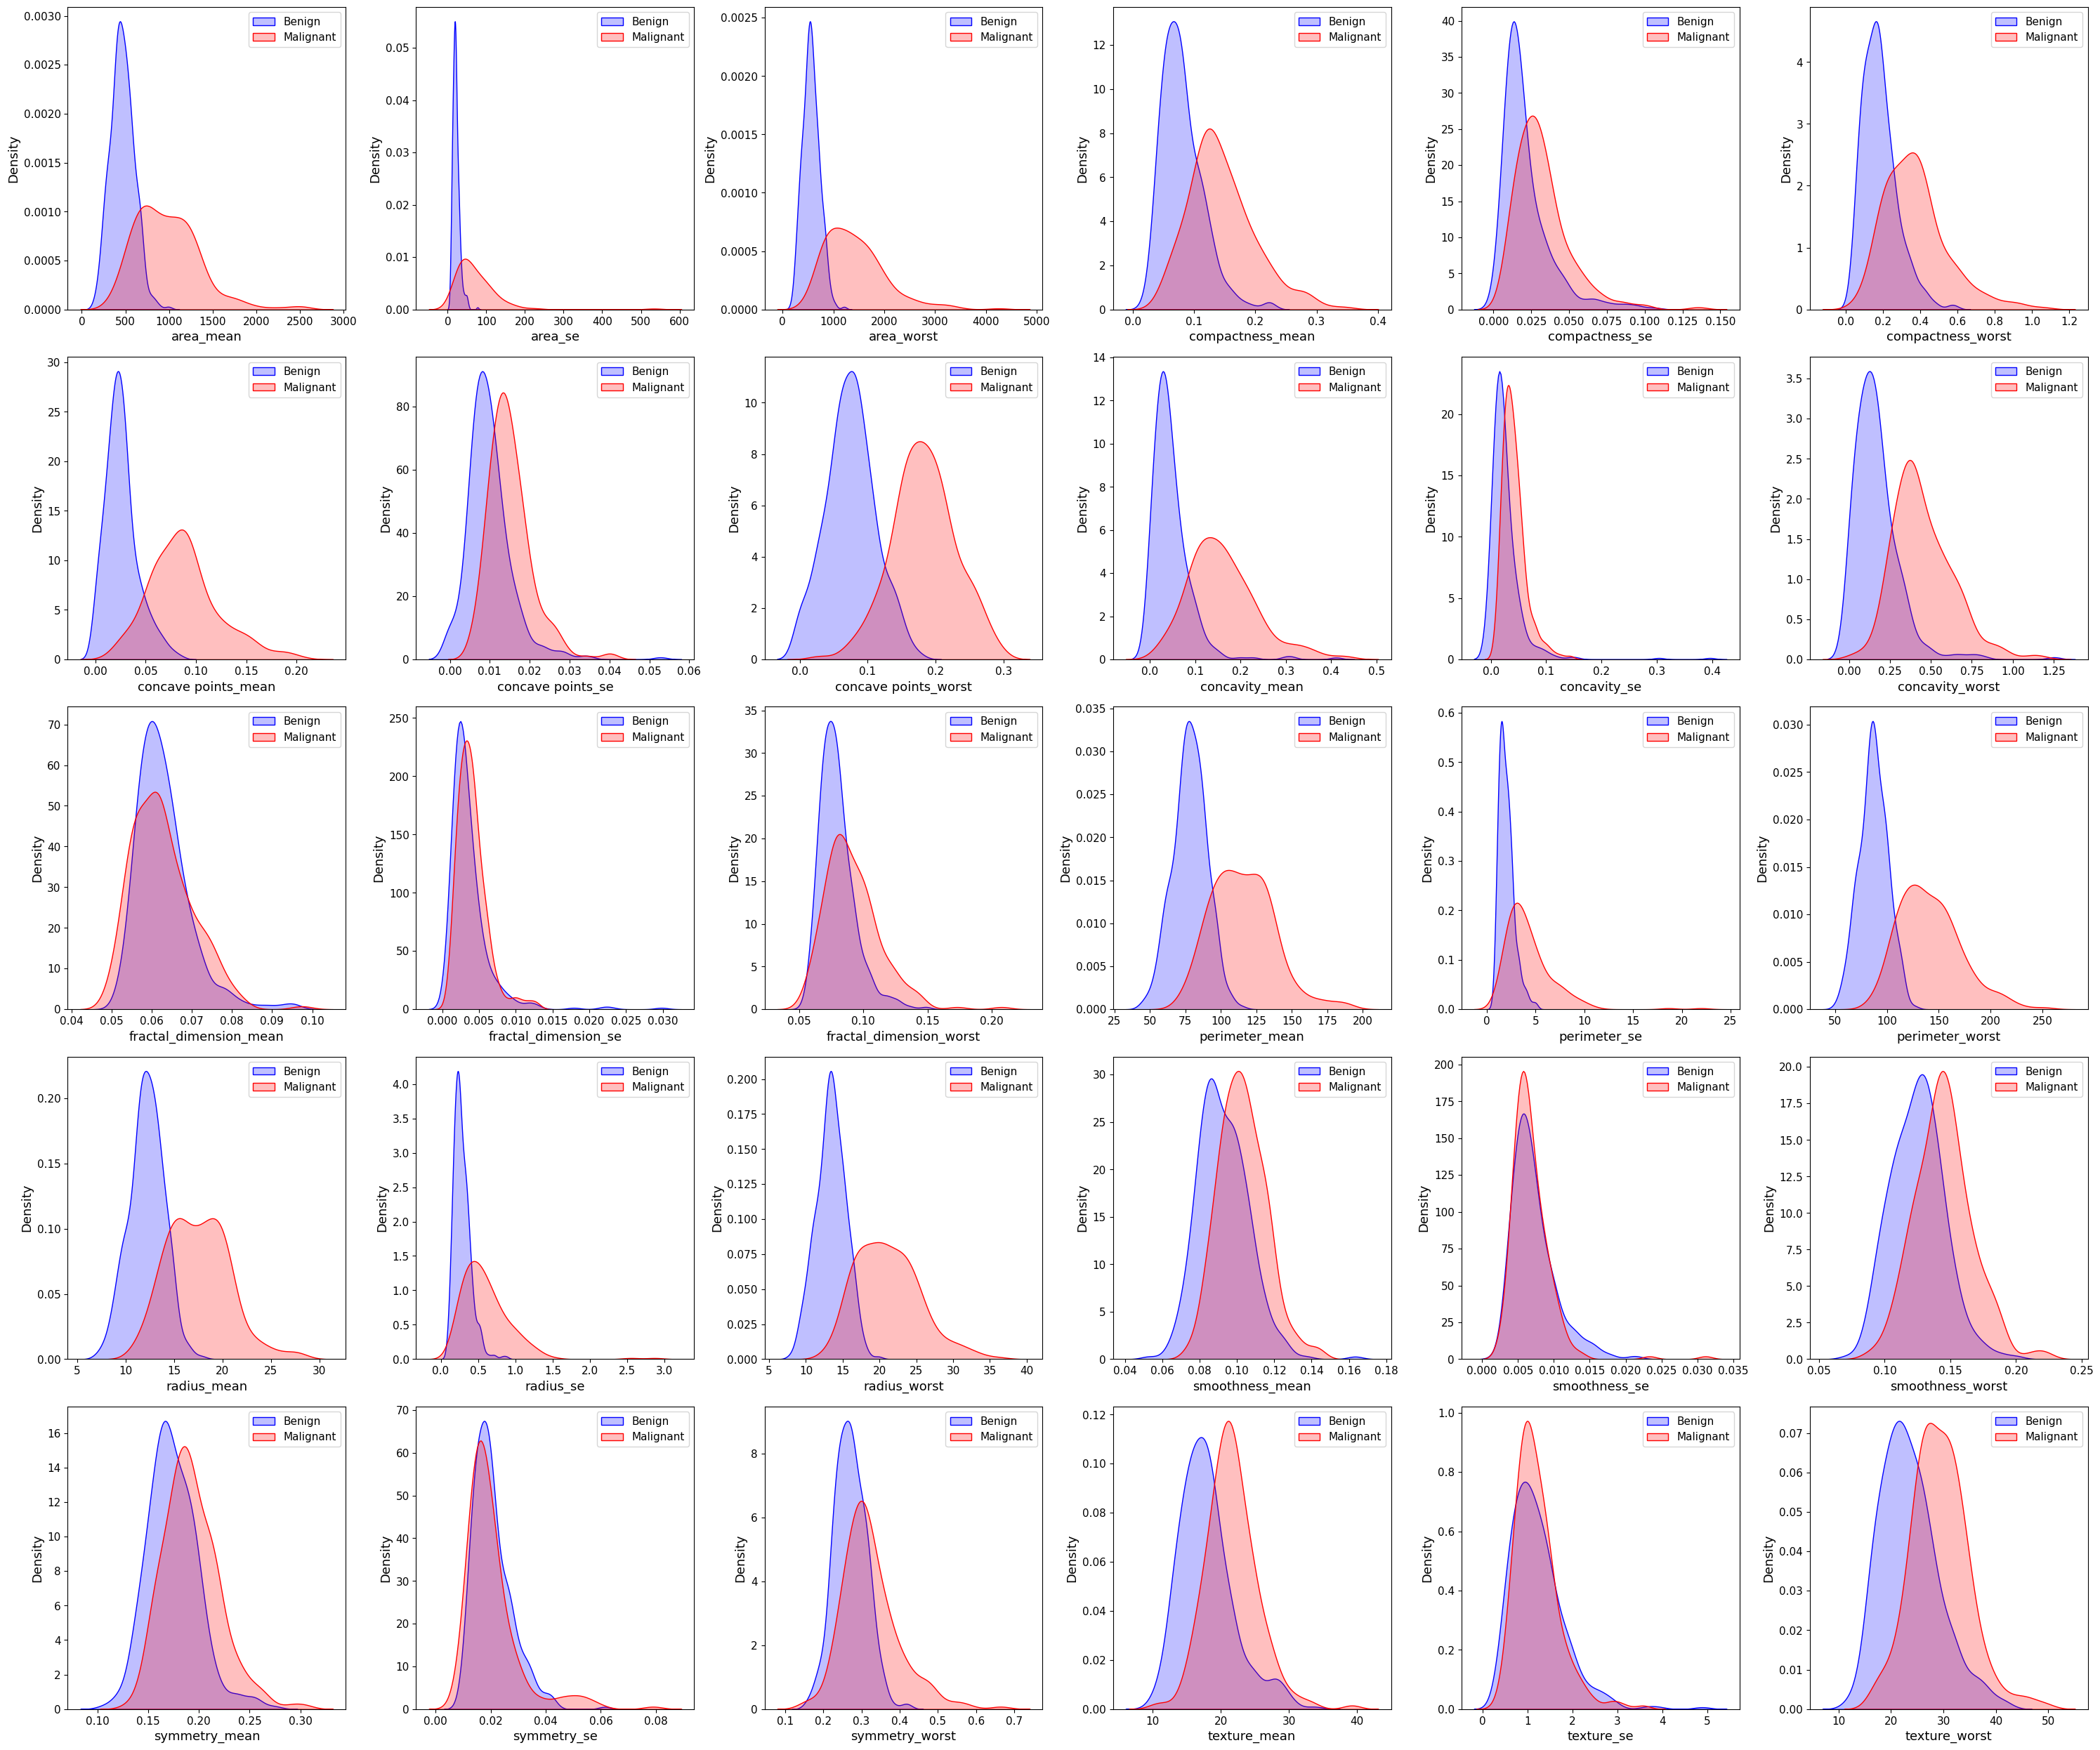

In [ ]:
num_features = len(features_sorted_alpha)
num_columns = 6
num_rows = num_features // num_columns + (1 if num_features % num_columns > 0 else 0)

width_per_subplot = height_per_subplot = 5
plt.figure(figsize=(width_per_subplot * num_columns, height_per_subplot * num_rows))

# Adjust font sizes
fonts_scaler = 5
label_fontsize = 8  + fonts_scaler
tick_fontsize = 6  + fonts_scaler
legend_fontsize = 6  + fonts_scaler
log_scaled = False # log-scale visualization

def analyze_feature(feature, subplot_index):
    ax = plt.subplot(num_rows, num_columns, subplot_index)

    sns.kdeplot(df[df[LABEL] == "B"][feature], label="Benign", shade=True, color="blue", log_scale=log_scaled)
    sns.kdeplot(df[df[LABEL] == "M"][feature], label="Malignant", shade=True, color="red", log_scale=log_scaled)

    ax.legend(fontsize=legend_fontsize)
    ax.xaxis.label.set_size(label_fontsize)
    ax.yaxis.label.set_size(label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Analyze each feature and create a subplot
for index, feature in enumerate(features_sorted_alpha):
    analyze_feature(feature, index+1)


plt.tight_layout(pad=1.0, h_pad=1.0, w_pad=1.0, rect=[0, 0, 1, 1])
plt.show()

TBF

### 5.5 Collecting & Visualizing the Distribution of Outliers in the Dataset




Based on the visualizations provided, our goal is to estimate the number of outlier data points. Given that several features show a high degree of correlation, it is reasonable to infer that many outliers may come from the same samples, meaning that some samples could be outliers across multiple features. We'd like to observe these outlier samples and address some of them, which may cause skewness in our dataset or potentially lead to inaccurate model predictions. By identifying and managing these outliers, we can improve the overall quality of our data analysis and ensure more reliable outcomes.

In [ ]:
outliers_mask = pd.DataFrame(False, index=df[ID], columns=features_sorted_alpha)


def mark_outliers_by_diagnosis_with_id(df, features, whis=2.0):
    # Function to calculate and mark outliers within each diagnosis group, preserving sample IDs
    for diagnosis in df[LABEL].unique():
        diagnosis_group = df[df[LABEL] == diagnosis]
        for feature in features:
            Q1 = diagnosis_group[feature].quantile(0.25)
            Q3 = diagnosis_group[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - whis * IQR
            upper_bound = Q3 + whis * IQR

            # Mark outliers in the mask DataFrame, using id col to reference the correct samples
            outliers_indices = diagnosis_group[(diagnosis_group[feature] < lower_bound) | (diagnosis_group[feature] > upper_bound)][ID]
            outliers_mask.loc[outliers_indices, feature] = True

mark_outliers_by_diagnosis_with_id(df, features_sorted_alpha, WHIS)

In [ ]:
outliers_samples = outliers_mask[outliers_mask.any(axis=1)]
outliers_samples = outliers_samples.reset_index()
outliers_samples.head()

,id,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,842302,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,84348301,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,True,True,False,False,False
2,84501001,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,846226,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
4,852631,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


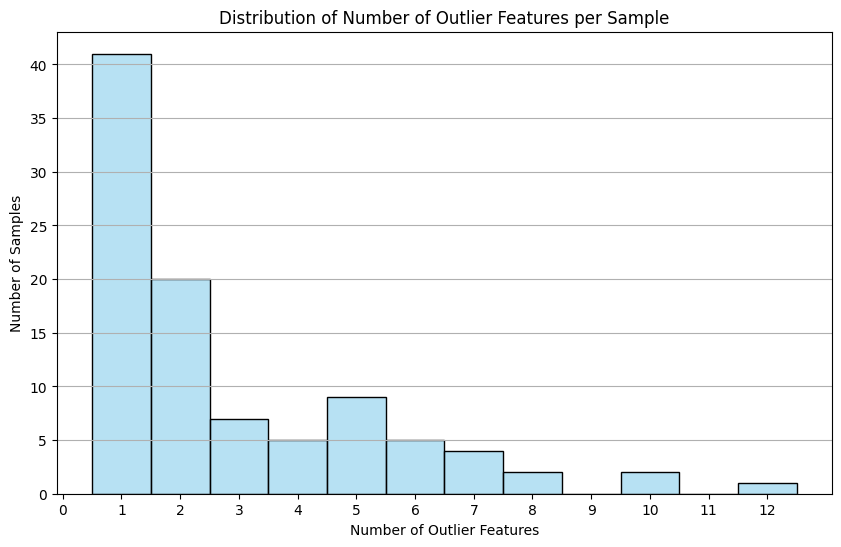

In [ ]:
outlier_counts = outliers_samples.drop(columns=[ID]).sum(axis=1)

plt.figure(figsize=(10, 6))

bins = np.arange(outlier_counts.min(), outlier_counts.max() + 2) - 0.5
sns.histplot(outlier_counts, bins=bins, stat='count', color='skyblue', alpha=0.6)

plt.title('Distribution of Number of Outlier Features per Sample')
plt.xlabel('Number of Outlier Features')
plt.ylabel('Number of Samples')
plt.xticks(range(int(outlier_counts.max()) + 1))
plt.grid(axis='y')
plt.show()

# 6. Model Training - XGBoost

## 6.1. Data preprocessing

### 6.1.1. Standardization (Z-score)

In [ ]:
training_df = training_df.apply(zscore)
# training_df = training_df.fillna(0)

### 6.1.2. Prepare the data

In [ ]:
X = training_df.values
y = df[LABEL].map({'M': 1, 'B': 0}).values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtest = xgb.DMatrix(X_test)

## 6.2. Training

### 6.2.1. Set XGBoost parameters

In [ ]:
evals_result = {}
params = {'objective': 'binary:logistic'}
num_of_folds = 10
kf = KFold(n_splits=num_of_folds, shuffle=True)
num_round = 10

### 6.2.2. Initialize lists to store the fold results

In [ ]:
bsts = []
metrics_summary = {'logloss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
best_fold = {'bst': None,
             'evals_result': {},
             'metrics': {'logloss': 0, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}}

### 6.2.3. Callback Function to evaluate XGBoost

Callback Function to evaluate XGBoost on custom metrics (precision, recall, accuracy, f1 score) during training
on train and validation data.

Args:
preds (list): The list of predicted probabilities output by the model.
data (DMatrix): The data on which evaluation is performed. Must have true labels.

Returns:
list: A list of tuples, each containing the name of the metric and its corresponding value.

In [ ]:
def eval_metrics(preds, data):
    labels = data.get_label() # Extract true labels from the data
    preds_binary = [int(p > 0.5) for p in preds] # Convert probabilities to binary output using threshold of 0.5

    # Calculate evaluation metrics
    accuracy = accuracy_score(labels, preds_binary)
    precision = precision_score(labels, preds_binary)
    recall = recall_score(labels, preds_binary)
    f1 = f1_score(labels, preds_binary)

    return [('accuracy', accuracy), ('precision', precision), ('recall', recall), ('f1', f1)]

### 6.2.4. Function to evaluate XGBoost model on test set

Evaluates the given booster on the test set and updates the metrics summary and best fold details.

This function computes the prediction probabilities for the positive class using the provided
booster model. It then converts these probabilities to binary predictions, calculates various
evaluation metrics (log loss, accuracy, precision, recall, F1 score), and updates the metrics
summary. Additionally, if the recall of the current booster is better than that of the best fold
stored, it updates the best fold information with the current booster's details and metrics.

Parameters:
- bst: xgboost.Booster
  The booster model for which evaluation is to be done.
- metrics_summary: dict
  A dictionary to store lists of metric values for each fold.
- best_fold: dict
  A dictionary storing the best fold's booster, evaluation results, and metrics.

In [ ]:
def eval_on_test(bst, metrics_summary=metrics_summary, best_fol=best_fold):
    # Evaluate on test set
    pred_probs = bst.predict(dtest)  # Get the prediction probabilities for the positive class
    pred_labels = (pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Calculate evaluation metrics
    logloss = log_loss(Y_test, pred_probs)
    accuracy = accuracy_score(Y_test, pred_labels)
    precision = precision_score(Y_test, pred_labels, zero_division=1)
    recall = recall_score(Y_test, pred_labels, zero_division=1)
    f1 = f1_score(Y_test, pred_labels, zero_division=1)

    # Update metrics summary with current evaluation metrics
    for k, v in {'logloss': logloss, 'accuracy': accuracy, 'f1': f1,
                  'precision': precision, 'recall': recall}.items():
        metrics_summary[k].append(v)

    # Update best fold information if current recall is better
    if best_fold['metrics']['recall'] < recall:
        best_fold['bst'] = bst
        best_fold['evals_result'] = evals_result
        for k, v in {'logloss': logloss, 'accuracy': accuracy, 'f1': f1,
                     'precision': precision, 'recall': recall}.items():
                     best_fold['metrics'][k] = v

### 6.2.5. Training loop for the 10 different XGBoost models

Splits the training data into train and validation sets according to the current fold,
converts them into DMatrix format required by XGBoost, trains a model, and evaluates it on the test set.

This loop iterates over each fold of a K-Fold cross-validation process, performing the following steps:
1. Splitting the training data into a training set and a validation set based on the indices provided by the current fold.
2. Converting these subsets into DMatrix, XGBoost's internal data structure optimized for both memory efficiency and training speed.
3. Training an XGBoost model using the training data, the validation data for early stopping (if applicable), and custom evaluation metrics.
4. Appending the trained model to a list for further use or analysis.
5. Calling a function to evaluate the trained model on a separate test set, updating a summary of metrics, and potentially identifying the best model based on specific criteria.

In [ ]:
# Loop over each fold defined by KFold split
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    # Split the training data according to the current fold
    x_train, x_val = X_train[train_index], X_train[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    # Convert the training and validation sets into DMatrix format
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)

    # Train the model using the training and validation sets
    bst = xgb.train(params, dtrain, num_round, [(dtrain, 'train'), (dval, 'val')], custom_metric=eval_metrics, evals_result=evals_result, verbose_eval=False)
    bsts.append(bst) # Append the trained model to the list of booster objects

    # Evaluate the model on the test set
    eval_on_test(bst)

## 6.3. Evaluation Metrics and Results

### 6.3.1. Function to plot training and validation graphs

This function is designed to plot a row of graphs, each representing the progression of a specific metric over epochs for both training and validation phases. It's particularly useful for visually comparing the performance of a model across multiple metrics simultaneously.

#### Parameters:
- `evals_results`: A dictionary containing the evaluation results. It should have separate keys for 'train' and 'val' (validation), each mapping to a dictionary of metric names and their values across epochs.
- `metrics`: A list of strings, where each string is the name of a metric to be plotted (e.g., 'accuracy', 'loss').
- `figsize`: A tuple specifying the width and height of the figure containing all the plots. Defaults to (20, 3).

In [ ]:
def plot_metrics_row(evals_results, metrics, figsize=(20, 3), lw=2):
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)  # 1 row, n columns where n is the number of metrics

    for ax, metric in zip(axes, metrics):
        epochs = len(evals_results['train'][metric])
        x_axis = range(0, epochs)

        ax.plot(x_axis, evals_results['train'][metric], label=f'{metric}_train', color='blue', lw=lw)
        ax.plot(x_axis, evals_results['val'][metric], label=f'{metric}_val', color='orange', lw=lw)

        ax.set_title(f'Best Fold - {metric}')
        ax.set_ylabel(metric)
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.tight_layout()
    plt.show()

### 6.3.2. Plot evaluation metrics for the best performing fold

This section of the code is dedicated to visualizing the progression of various evaluation metrics over epochs for the best-performing fold in a cross-validation process. It leverages the `plot_metrics_row` function defined earlier to create a row of plots, each corresponding to a different metric. The visualization aims to provide insights into the model's learning dynamics and performance consistency across different measures of success.

A list named `metrics` is defined, containing the names of the evaluation metrics to be visualized: 'logloss', 'accuracy', 'precision', 'recall', and 'f1'. These metrics cover a broad spectrum of performance aspects, from loss minimization to predictive accuracy and balance between precision and recall.

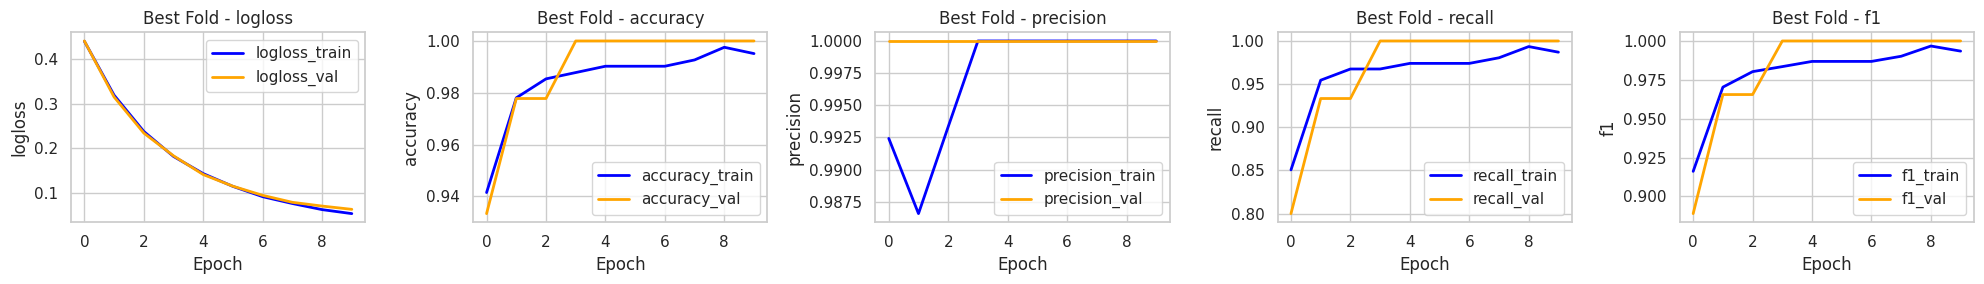

In [ ]:
# Set seaborn style
sns.set(style='whitegrid')

# Define the list of metrics
metrics = ['logloss', 'accuracy', 'precision', 'recall', 'f1']

# Call the function with the appropriate parameters
plot_metrics_row(best_fold['evals_result'], metrics)

### 6.3.3. Plot ROC curve for the best performing fold on the test set

This section focuses on plotting the Receiver Operating Characteristic (ROC) curve to evaluate the predictive performance of the best model from a cross-validation process on the test set. The ROC curve is a graphical representation that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

- **Prediction Probabilities**: First, prediction probabilities for the positive class are obtained from the best model (`best_fold['bst']`) using the test dataset (`dtest`).

- **ROC Curve Computation**: The `roc_curve` function is used to compute the false positive rate (FPR), true positive rate (TPR), and thresholds needed to plot the ROC curve. These metrics are derived by comparing the prediction probabilities against the actual labels in `Y_test`.

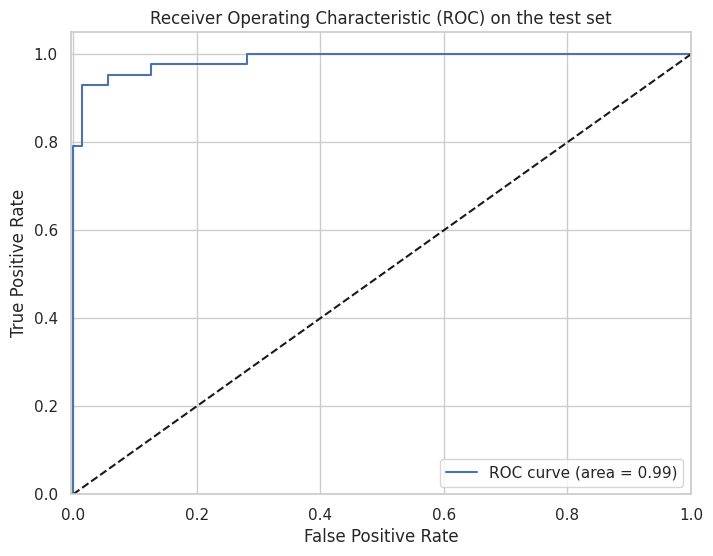

In [ ]:
# Plot the ROC curve
pred_probs = best_fold['bst'].predict(dtest) # Get the prediction probabilities for the positive class from the best model
fpr, tpr, thresholds = roc_curve(Y_test, pred_probs) # Compute the false positive rate, true positive rate, and thresholds for the ROC curve

# Initialize the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.0035, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on the test set')
plt.legend(loc="lower right")
plt.show()

### 6.3.4. Summary of all models and best fold performance

Iterates over metrics ('logloss', 'accuracy', 'precision', 'recall', 'f1'), converting each metric's
cross-validation results into a NumPy array for statistical analysis. For each metric, it prints the
average and standard deviation of its cross-validation results, alongside the metric's value from the
best performing fold. This provides insights into the model's general and best-case performance on the
test data.

We then this values in a pandas dataframe object and present it.

In [ ]:
# Initialize an empty list to store the rows of the table
rows = []

# Iterate through each specified metric to process and accumulate results
for met in ('logloss', 'accuracy', 'precision', 'recall', 'f1'):
    # Convert the list of metric values to a NumPy array for easier statistical operations
    metrics_summary[met] = np.array(metrics_summary[met])

    # Calculate the average and standard deviation of cross-validation results for the current metric
    # and round the result to 3 decimal places
    avg = round(np.mean(metrics_summary[met]), 3)
    std = round(np.std(metrics_summary[met]), 3)

    # Retrieve the metric's value for the best fold and round it to 3 decimal places
    best = round(best_fold['metrics'][met], 3)

    # Append the results as a new row in the list
    rows.append([met, avg, std, best])

# Create a DataFrame from the accumulated rows
df_metrics = pd.DataFrame(rows, columns=['Metric', 'CV_Mean_on_Test', 'CV_STD_on_Test', 'Best_Fold_on_Test'])

df_metrics

,Metric,CV_Mean_on_Test,CV_STD_on_Test,Best_Fold_on_Test
0,logloss,0.131,0.017,0.142
1,accuracy,0.961,0.006,0.956
2,precision,0.964,0.016,0.952
3,recall,0.930,0.000,0.930
4,f1,0.947,0.008,0.941
